In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

In [2]:
tf.__version__

'2.9.2'

In [105]:
import h5py
import numpy as np
import tensorflow as tf
import math

def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    

In [9]:
train_dataset = h5py.File('Datasets/train_signs.h5', "r")
test_dataset = h5py.File('Datasets/test_signs.h5', "r")

In [10]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [11]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [12]:
print(x_train.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [13]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [14]:
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

{0, 1, 2, 3, 4, 5}


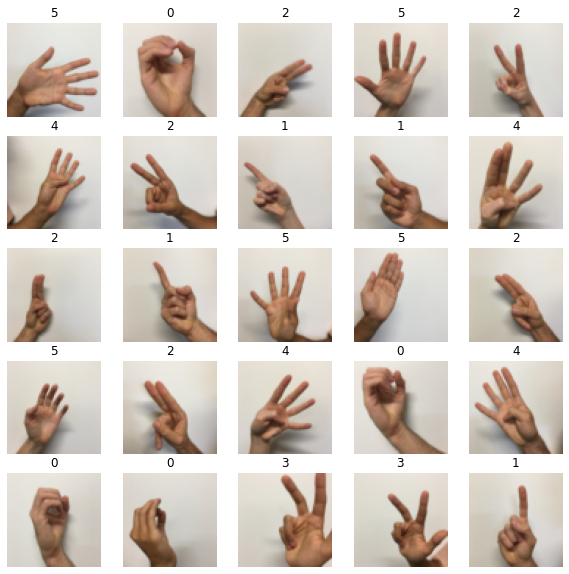

In [15]:
images_iter = iter(x_train)
labels_iter = iter(y_train)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

In [16]:
def normalize(image):
    """
    Transform an image into a tensor of shape (64 * 64 * 3, )
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
    return image

In [17]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [18]:
new_train.element_spec

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [19]:
print(next(iter(new_train)))

tf.Tensor([0.8901961  0.8627451  0.8392157  ... 0.8156863  0.81960785 0.81960785], shape=(12288,), dtype=float32)


In [20]:
# GRADED FUNCTION: linear_function

def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """

    np.random.seed(1)
    
    """
    Note, to ensure that the "random" numbers generated match the expected results,
    please create the variables in the order given in the starting code below.
    (Do not re-arrange the order).
    """
    # (approx. 4 lines)
    # X = ...
    # W = ...
    # b = ...
    # Y = ...
    # YOUR CODE STARTS HERE
    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.constant(np.random.randn(4,3), name = "W")
    b = tf.constant(np.random.randn(4,1), name = "b")
    Y = tf.add(tf.matmul(W,X),b)
    # YOUR CODE ENDS HERE
    return Y

In [21]:
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll test passed")


tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All test passed


In [61]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """
    # tf.keras.activations.sigmoid requires float16, float32, float64, complex64, or complex128.
    
    # (approx. 2 lines)
    # z = ...
    # a = ...
    # YOUR CODE STARTS HERE
    z = tf.cast(z,tf.float32)
    a = tf.keras.activations.sigmoid(z)
    # YOUR CODE ENDS HERE
    return a


In [62]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"
    assert sigmoid(12) == 0.99999386, "Error"

    print("\033[92mAll test passed")

sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.99999386, shape=(), dtype=float32)
All test passed


In [69]:
# GRADED FUNCTION: one_hot_matrix
def one_hot_matrix(label, depth=6):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    # (approx. 1 line)
    # one_hot = None(None(None, None, None), shape=[-1, ])
    # YOUR CODE STARTS HERE
    one_hot = tf.one_hot(label,depth,axis=0)
    one_hot = tf.reshape(one_hot,[-1])
    # YOUR CODE ENDS HERE
    return one_hot

In [70]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print("Test 1:",result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 1. ,0., 0.] ), "Wrong output. Use tf.one_hot"
    label_2 = [2]
    result = target(label_2, depth)
    print("Test 2:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 0. ,1., 0.] ), "Wrong output. Use tf.reshape as instructed"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
All test passed


In [71]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [72]:
print(next(iter(new_y_test)))

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


In [75]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    #(approx. 6 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # W3 = ...
    # b3 = ...
    # YOUR CODE STARTS HERE
    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6, 12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))
    
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [76]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


In [77]:
parameters = initialize_parameters()

In [78]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #(approx. 5 lines)                   # Numpy Equivalents:
    # Z1 = ...                           # Z1 = np.dot(W1, X) + b1
    # A1 = ...                           # A1 = relu(Z1)
    # Z2 = ...                           # Z2 = np.dot(W2, A1) + b2
    # A2 = ...                           # A2 = relu(Z2)
    # Z3 = ...                           # Z3 = np.dot(W3, A2) + b3
    # YOUR CODE STARTS HERE
    Z1 = tf.add(tf.matmul(W1,X),b1)    # Z1 = np.dot(W1, X) + b1
    A1 = tf.keras.activations.relu(Z1) # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)   # Z2 = np.dot(W2, A1) + b2
    A2 = tf.keras.activations.relu(Z2) # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)   # Z3 = np.dot(W3, A2) + b3
    
    # YOUR CODE ENDS HERE
    
    return Z3

In [ ]:
def forward_propagation_test(target, examples):
    minibatches = examples.batch(2)
    parametersk = initialize_parameters()
    W1 = parametersk['W1']
    b1 = parametersk['b1']
    W2 = parametersk['W2']
    b2 = parametersk['b2']
    W3 = parametersk['W3']
    b3 = parametersk['b3']
    index = 0
    minibatch = list(minibatches)[0]
    with tf.GradientTape() as tape:
        forward_pass = target(tf.transpose(minibatch), parametersk)
        print(forward_pass)
        fake_cost = tf.reduce_mean(forward_pass - np.ones((6,2)))

        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 2), "Last layer must use W3 and b3"
        assert np.allclose(forward_pass, 
                           [[-0.13430887,  0.14086473],
                            [ 0.21588647, -0.02582335],
                            [ 0.7059658,   0.6484556 ],
                            [-1.1260961,  -0.9329492 ],
                            [-0.20181894, -0.3382722 ],
                            [ 0.9558965,   0.94167566]]), "Output does not match"
    index = index + 1
    trainable_variables = [W1, b1, W2, b2, W3, b3]
    grads = tape.gradient(fake_cost, trainable_variables)
    assert not(None in grads), "Wrong gradients. It could be due to the use of tf.Variable whithin forward_propagation"
    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

In [98]:
# GRADED FUNCTION: compute_total_loss 

def compute_total_loss(logits, labels):
    """
    Computes the total loss
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    
    #(1 line of code)
    # total_loss = ...
    # YOUR CODE STARTS HERE
    total_loss = tf.reduce_mean(tf.keras.metrics.categorical_crossentropy(tf.transpose(labels),tf.transpose(logits),from_logits=True))

    # YOUR CODE ENDS HERE
    return total_loss

In [ ]:
def compute_total_loss_test(target, Y):
    pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
    minibatches = Y.batch(2)
    for minibatch in minibatches:
        result = target(pred, tf.transpose(minibatch))
        break
        
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.50722074 + 1.1133534) / 2.0) < 1e-7), "Test does not match. Did you get the reduce sum of your loss functions?"

    print("\033[92mAll test passed")

compute_total_loss_test(compute_total_loss, new_y_train )

In [100]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    #(1 line)
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    #X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    #Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_total_loss = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches:
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # 2. loss
                minibatch_total_loss = compute_total_loss(Z3, tf.transpose(minibatch_Y))

            # We accumulate the accuracy of all the batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_total_loss += minibatch_total_loss
        
        # We divide the epoch total loss over the number of samples
        epoch_total_loss /= m

        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_total_loss))
            print("Train accuracy:", train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()


    return parameters, costs, train_acc, test_acc

In [102]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=200)

Cost after epoch 0: 0.056965
Train accuracy: tf.Tensor(0.16944444, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.16666667, shape=(), dtype=float32)
Cost after epoch 10: 0.054255
Train accuracy: tf.Tensor(0.19444445, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.16666667, shape=(), dtype=float32)
Cost after epoch 20: 0.051302
Train accuracy: tf.Tensor(0.27592593, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.3, shape=(), dtype=float32)
Cost after epoch 30: 0.048132
Train accuracy: tf.Tensor(0.33425927, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.35833332, shape=(), dtype=float32)
Cost after epoch 40: 0.045467
Train accuracy: tf.Tensor(0.38981482, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.4, shape=(), dtype=float32)
Cost after epoch 50: 0.043379
Train accuracy: tf.Tensor(0.42407408, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.48333332, shape=(), dtype=float32)
Cost after epoch 60: 0.041562
Train accuracy: tf.Tensor(0.4564815, shape=(), dtype=fl

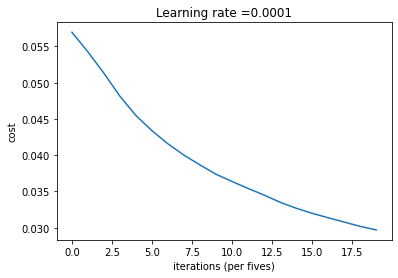

In [103]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

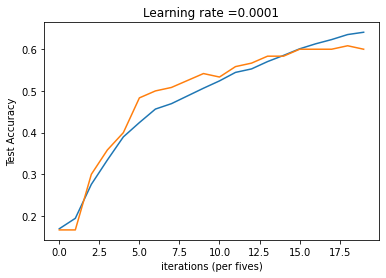

In [104]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()
